Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

Begin Data Cleaning

In [2]:
# read file
df = pd.read_csv(r'C:\Users\krist\Downloads\SN_m_tot_V2.0.csv', sep=';')

In [3]:
# inspect data
df.head()

,1749,01,1749.042,96.7,-1.0,-1,1
0,1749,2,1749.123,104.3,-1.0,-1,1
1,1749,3,1749.204,116.7,-1.0,-1,1
2,1749,4,1749.288,92.8,-1.0,-1,1
3,1749,5,1749.371,141.7,-1.0,-1,1
4,1749,6,1749.455,139.2,-1.0,-1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   1749      3279 non-null   int64  
 1   01        3279 non-null   int64  
 2   1749.042  3279 non-null   float64
 3     96.7    3279 non-null   float64
 4    -1.0     3279 non-null   float64
 5      -1     3279 non-null   int64  
 6   1         3279 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 179.4 KB


In [5]:
# check for duplicated rows
df[df.duplicated()]

,1749,01,1749.042,96.7,-1.0,-1,1


In [6]:
# check for missing values
df.isna().sum()

1749        0
01          0
1749.042    0
  96.7      0
 -1.0       0
   -1       0
1           0
dtype: int64

In [7]:
# clean column names
df.columns = df.columns.str.strip()
print(df.columns)

Index(['1749', '01', '1749.042', '96.7', '-1.0', '-1', '1'], dtype='object')


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   1749      3279 non-null   int64  
 1   01        3279 non-null   int64  
 2   1749.042  3279 non-null   float64
 3   96.7      3279 non-null   float64
 4   -1.0      3279 non-null   float64
 5   -1        3279 non-null   int64  
 6   1         3279 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 179.4 KB


In [9]:
# combine Year and Month columns into a single Date column (ds for Prophet)
df['Date'] = pd.to_datetime(df[['1749', '01']].astype(str).agg('-'.join, axis=1))

In [10]:
# prepare data 
df_prophet = df[['Date', '96.7']].rename(columns={'Date': 'ds', '96.7': 'y'})

In [11]:
# rename columns for prophet
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')

In [12]:
print(df_prophet.head())

          ds      y
0 1749-02-01  104.3
1 1749-03-01  116.7
2 1749-04-01   92.8
3 1749-05-01  141.7
4 1749-06-01  139.2


Once again, we lost the first row of the data since it was the header, but since it's only one value I don't think it will matter too much.

Fit Model

In [13]:
# split data
train_size = int(len(df_prophet) * 0.8)
df_train = df_prophet[:train_size]
df_test = df_prophet[train_size:]

In [14]:
# make list for periods and frequencies
periods_list = [1, 6, 9]
freq_list = ['ME', 'ME', 'ME']

In [15]:
# define function for forecasts
def forecast_sunspots(df_train, periods_list, freq_list):
    forecasts = {}
    # initialize and fit model
    model = Prophet()
    model.fit(df_train)
    # loop through periods and frequencies to generate forecasts
    for period, freq in zip(periods_list, freq_list):
        future = model.make_future_dataframe(periods=period, freq=freq)
        forecast = model.predict(future)
        forecast_future = forecast[forecast['ds'] > df_train['ds'].max()]
        forecasts[period] = forecast_future
    return forecasts

In [16]:
print(df_prophet.columns)

Index(['ds', 'y'], dtype='object')


In [17]:
# call functions for different periods
forecasts = forecast_sunspots(df_train, periods_list, freq_list)

00:51:39 - cmdstanpy - INFO - Chain [1] start processing
00:51:40 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
print(forecasts)

{1:              ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2623 1967-08-31  114.158457   27.719223  199.503232   114.158457   114.158457   

      additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
2623        2.327194              2.327194              2.327194  2.327194   

      yearly_lower  yearly_upper  multiplicative_terms  \
2623      2.327194      2.327194                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper        yhat  
2623                         0.0                         0.0  116.485651  , 6:              ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2623 1967-08-31  114.158457   34.437939  196.797475   114.158457   114.158457   
2624 1967-09-30  114.228155   34.473281  198.619489   114.228155   114.228155   
2625 1967-10-31  114.300177   20.425860  192.926936   114.300177   114.300177   
2626 1967-11-30  114.369875   32.581845  194.840000   114.369875   114.369875   


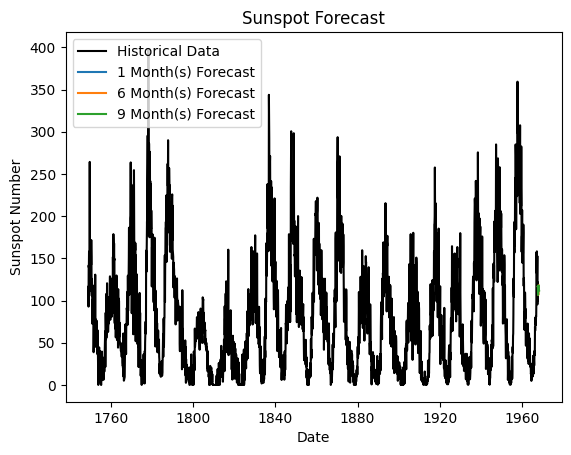

In [76]:
# plot both the historical data and the forecasts on one graph
# historical data
plt.plot(df_train['ds'], df_train['y'], label='Historical Data', color='black')
# loop forecasts
for period, forecast in forecasts.items():
    plt.plot(forecast['ds'], forecast['yhat'], label=f'{period} Month(s) Forecast')
# plot forecasts
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Forecast')
plt.legend()
# show the plot
plt.show()

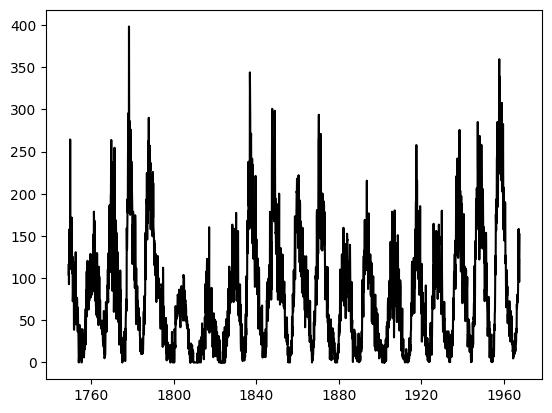

In [19]:
# plot historical data for alone comparison
plt.plot(df_train['ds'], df_train['y'], label='Historical Data', color='black')

In [20]:
# ensure that the forecasts are correctly formatted
for period, forecast in forecasts.items():
    print(f"Forecast for {period} months:")
    print(forecast[['ds', 'yhat']].head()) 

Forecast for 1 days:
             ds        yhat
2623 1967-08-31  116.485651
Forecast for 6 days:
             ds        yhat
2623 1967-08-31  116.485651
2624 1967-09-30  116.059029
2625 1967-10-31  106.701559
2626 1967-11-30  112.556267
2627 1967-12-31  111.915735
Forecast for 9 days:
             ds        yhat
2623 1967-08-31  116.485651
2624 1967-09-30  116.059029
2625 1967-10-31  106.701559
2626 1967-11-30  112.556267
2627 1967-12-31  111.915735


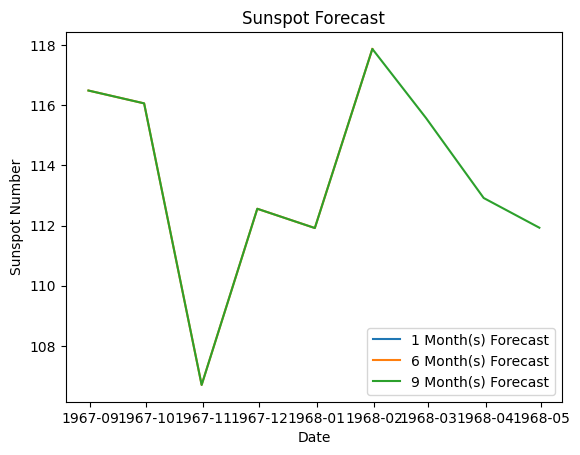

In [21]:
# plot forecasts for the three different periods
for period, forecast in forecasts.items():
    plt.plot(forecast['ds'], forecast['yhat'], label=f'{period} Month(s) Forecast')

plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Forecast')
plt.legend()
plt.show()

Once again, I want to separate the plots to make sure they are all there.

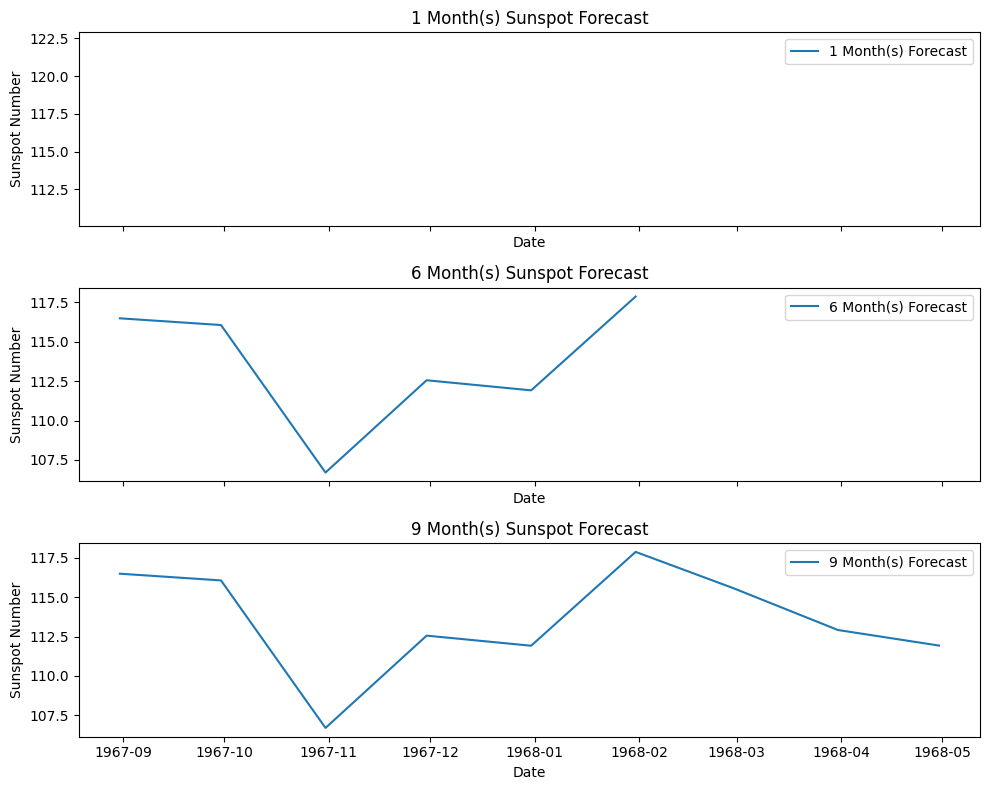

In [22]:
# create subplots
fig, axes = plt.subplots(len(forecasts), 1, figsize=(10, 8), sharex=True)

# plot each forecast in a different subplot
for ax, (period, forecast) in zip(axes, forecasts.items()):
    ax.plot(forecast['ds'], forecast['yhat'], label=f'{period} Month(s) Forecast')
    ax.set_title(f'{period} Month(s) Sunspot Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sunspot Number')
    ax.legend()

# adjust the layout to avoid overlap
plt.tight_layout()
plt.show()

I can't seem to get the one month graph to plot, but I am assuming it may be because there is only one data point there. Nonetheless, the six and nine month graphs plotted well. Again, the forecasted values seem a bit low compared to the historical data, but it does make sense since the end of the historical data seems to take a dip towards the end. 

Evaluate Model

In [23]:
# standardize both dataframes since there was a slight mismatch in date format
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.to_period('M').dt.start_time
forecast['ds'] = pd.to_datetime(forecast['ds']).dt.to_period('M').dt.start_time

In [24]:
# merge actual data and forecast
df_comparison = pd.merge(forecast[['ds', 'yhat']], df_prophet[['ds','y']], on='ds', how='inner')

In [25]:
# calculate MAE, MAPE, and R^2
mae = mean_absolute_error(df_comparison['y'], df_comparison['yhat'])
mape = mean_absolute_percentage_error(df_comparison['y'], df_comparison['yhat'])
r2 = r2_score(df_comparison['y'], df_comparison['yhat'])

In [26]:
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

MAE: 29.702845843073607
MAPE: 0.19200923097114972
R²: -1.3470766473382096


Here, my MAE and MAPE are relatively good considering the dataset at hand. Once again the R^2 is subpar, but, once again, this can hopefully be improved with my parameter tuning.

Tune the Model on Different Parameters

Forecasting Growth

Once again, I am going with logisitic growth because of the fluctuating nature of the data and the fact that there seems to be a cap. I chose my cap to be 450 since the maximum value in the historical data looks to be a little over 400. I will also reduce my dataset for the sake of the code being able to run it in a reasonable amount of time.

In [27]:
# reduce data
df_train_subset = df_train.tail(200)

In [28]:
# create capacity column (upper limit)
df_train_subset['cap'] = 450

C:\Users\krist\AppData\Local\Temp\ipykernel_25016\3181649875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_subset['cap'] = 450


In [29]:
# tune parameter
model = Prophet(growth='logistic')
model.fit(df_train_subset)

00:51:48 - cmdstanpy - INFO - Chain [1] start processing
00:51:48 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# prepare dataframe for forecasting
future = model.make_future_dataframe(periods=9)

In [31]:
# add cap column
future['cap'] = 450

In [32]:
# make forecast
forecast = model.predict(future)

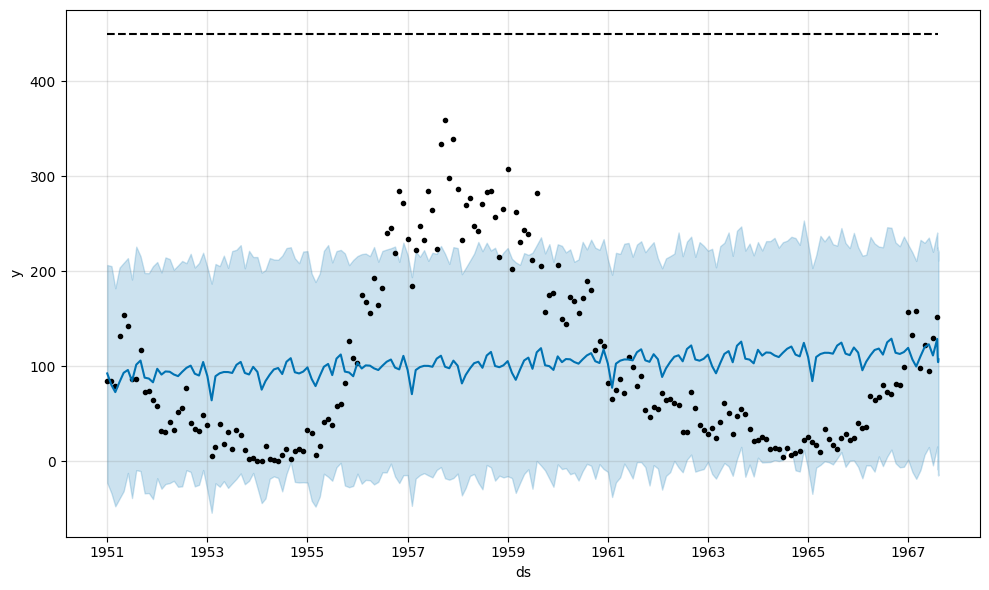

In [33]:
# plot
model.plot(forecast)
plt.show()

This model doesn't seem very convincing, but it also isn't the worst. While the line seems to be following the same pattern all throughout, there is quite a bit of variance in the background, but it is consistent.

Seasonality

In [34]:
# add custom daily seasonality and a fourier order of 10
model = Prophet(growth='logistic')
model.add_seasonality(name='monthly', period=9, fourier_order=10)
model.fit(df_train_subset)

00:52:37 - cmdstanpy - INFO - Chain [1] start processing
00:52:37 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
# prepare dataframe for forecasting
future = model.make_future_dataframe(periods=9)

In [36]:
# add cap column
future['cap'] = 450

In [37]:
# make forecast
forecast = model.predict(future)

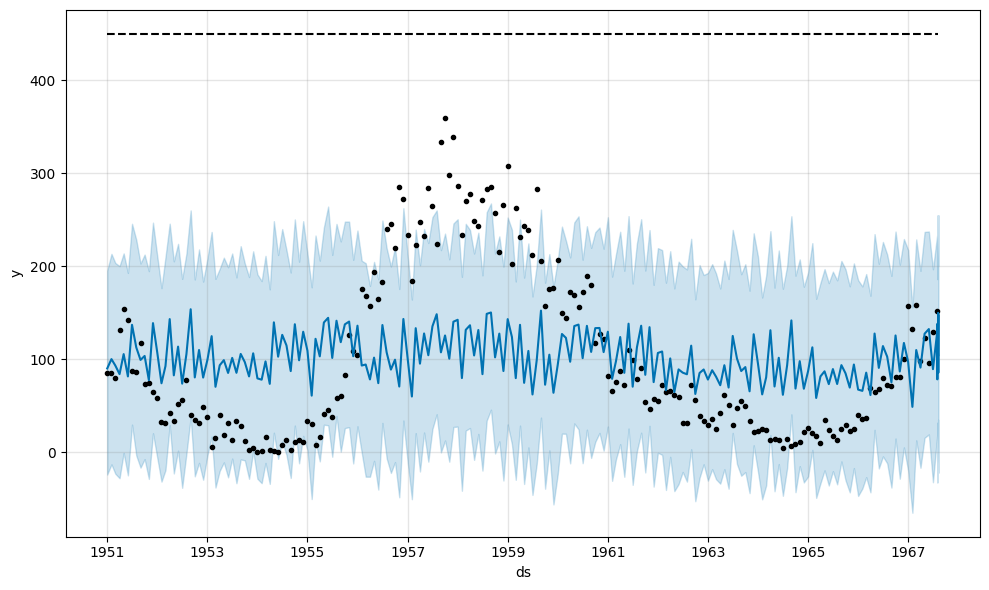

In [38]:
# plot
model.plot(forecast)
plt.show()

This looks a bit better than the last graph since there are more fluctuations in the line, and it's still going up consistently.

Trend Changepoints

In [39]:
# add cap column
df_train_subset['cap'] = 450

C:\Users\krist\AppData\Local\Temp\ipykernel_25016\3425978060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_subset['cap'] = 450


In [67]:
# initialize model with tuning parameters
model = Prophet(
    growth='logistic',
    changepoint_prior_scale=0.5,
    n_changepoints=10)
model.add_seasonality(name='monthly', period=9, fourier_order=10)

In [68]:
# fit the model
model.fit(df_train_subset)

01:03:37 - cmdstanpy - INFO - Chain [1] start processing
01:03:37 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
# prepare dataframe for forecasting
future = model.make_future_dataframe(periods=9)

In [70]:
# add cap column
future['cap'] = 450

In [71]:
# make forecast
forecast = model.predict(future)

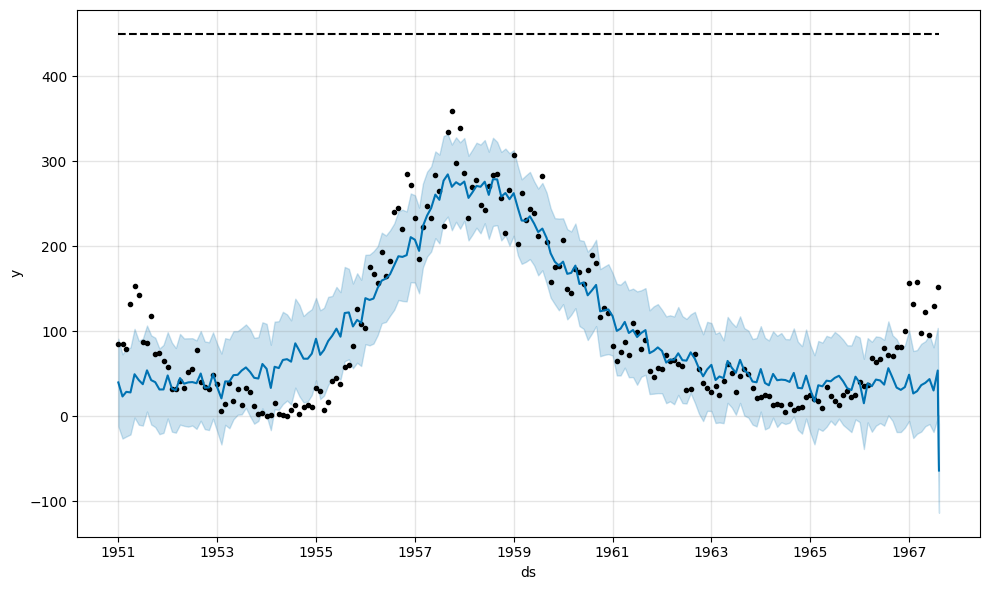

In [72]:
# plot
model.plot(forecast)
plt.show()

After tinkering with my parameter numbers for a bit, this was the best I could get it to follow the pattern. It seems to take a drastic dip in the end, but the error rates are not too terrible, so I think it turned out alright.

In [73]:
# merge actual data and forecast
df_comparison = pd.merge(forecast[['ds', 'yhat']], df_prophet[['ds','y']], on='ds', how='inner')

In [74]:
# calculate MAE, MAPE, and R^2
mae = mean_absolute_error(df_comparison['y'], df_comparison['yhat'])
mape = mean_absolute_percentage_error(df_comparison['y'], df_comparison['yhat'])
r2 = r2_score(df_comparison['y'], df_comparison['yhat'])

In [75]:
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

MAE: 30.379801046175217
MAPE: 3.170656106068626
R²: 0.8043325426238889


Even though the MAE and MAPE worsened a bit, the R^2 improved a lot which outweighs the the other two for me. The R^2 is an overall metric for how the predicted and actual values compare and the MAE and MAPE didn't worsen by too much. In the future, I would definitely like to investigate this a bit more to see why the graph seems to depict a different story.